<a href="https://colab.research.google.com/github/YossefMohamed/Detecting-COVID-19-Through-Sound/blob/main/virufycompletemodel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os


1-Prepare Data

**Download** **Data**

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git


fatal: destination path 'Coswara-Data' already exists and is not an empty directory.


In [ ]:


rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];



20210930
20200419
20201221
20210426
20200502
20210603
20200418
20200504
20200413
20210830
20200525
20200820
20210618
20210206
20201012
20200901
20210507
20210914
20210816
20200803
20200707
20200919
20200430
20210714
20200417
20210419
20200911
20200814
20200424
20201130
20200720
20210523
20200930
20210630
20200416
20200415
20200824
20210406
20201031
20200604
20200505


In [ ]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-01-13 10:55:06--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  16.6MB/s    in 2m 5s   

2022-01-13 10:57:13 (7.27 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [ ]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData=pd.concat(df_list)
CosData['DataSet'] = 'coswara'
CosData.head()

100%|██████████| 2232/2232 [00:28<00:00, 77.66it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,dQEgRb1WIAOmomgTx4amrxbQ2513,positive_moderate,/content/Coswara-Data/20210930/dQEgRb1WIAOmomg...,0,1,coswara
0,eR2gfqeYAjdgzpwtCDXUqts9yIc2,positive_mild,/content/Coswara-Data/20210930/eR2gfqeYAjdgzpw...,0,1,coswara
0,IgwjLDmZRyTv03Mq7VdUYL6O5fV2,positive_moderate,/content/Coswara-Data/20210930/IgwjLDmZRyTv03M...,1,1,coswara
0,gpreuyMvtSa8HJhGaliJ6E1Hwx53,positive_asymp,/content/Coswara-Data/20210930/gpreuyMvtSa8HJh...,1,1,coswara
0,Z8ulmLPAsmhYfYuqUAmm6aGy5r53,positive_mild,/content/Coswara-Data/20210930/Z8ulmLPAsmhYfYu...,1,1,coswara



Prepare dataset
**bold text**

In [ ]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19'][0:1000]

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,kOBN8dMQckbYR0PtSZAxOciIcY62,healthy,/content/Coswara-Data/20200418/kOBN8dMQckbYR0P...,0,0,coswara
1,LuWrKc4LBRWEfrsF2sCdR7o57m12,healthy,/content/Coswara-Data/20200502/LuWrKc4LBRWEfrs...,0,0,coswara
2,trc6AC5IMYOoTnAeupgXR8YovHj1,resp_illness_not_identified,/content/Coswara-Data/20200419/trc6AC5IMYOoTnA...,0,0,coswara
3,28952e75-057b-41d2-a421-e9fe7db93aea,healthy,/content/public_dataset/28952e75-057b-41d2-a42...,0,1,coughvid
4,0pqMnxeSybfQnGV9nHW3P69FSzE3,positive_moderate,/content/Coswara-Data/20210618/0pqMnxeSybfQnGV...,0,0,coswara


Feature Extraction

In [ ]:


def feature_extractor(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[-4])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []



In [ ]:
for row in tqdm(TotData.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])

  0%|          | 0/3673 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/3673 [00:02<2:11:42,  2.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 4/3673 [00:04<52:07,  1.17it/s]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 6/3673 [00:05<42:53,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 11/3673 [00:08<38:36,  1.58it/s]/us

File cannot open


  4%|▎         | 135/3673 [01:36<27:51,  2.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 138/3673 [01:39<36:05,  1.63it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 139/3673 [01:40<42:59,  1.37it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 141/3673 [01:41<45:55,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 143/3673 [01:43<48:26, 

File cannot open


  6%|▋         | 233/3673 [02:50<35:55,  1.60it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 235/3673 [02:51<33:04,  1.73it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 236/3673 [02:52<42:51,  1.34it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 237/3673 [02:54<57:09,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 240/3673 [02:56<50:44, 

File cannot open


  9%|▉         | 327/3673 [04:06<1:16:49,  1.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


File cannot open


  9%|▉         | 331/3673 [04:09<51:18,  1.09it/s]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 335/3673 [04:11<37:02,  1.50it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 340/3673 [04:14<29:44,  1.87it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 341/3673 [04:16<42:24,  1.31it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 344/3673 [04:17<35:02

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 397/3673 [04:56<36:12,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 398/3673 [04:57<44:15,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 401/3673 [04:59<39:14,  1.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 402/3673 [05:00<40:54,  1.33it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


 12%|█▏        | 435/3673 [05:30<31:32,  1.71it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 437/3673 [05:32<39:41,  1.36it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 442/3673 [05:35<28:58,  1.86it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 444/3673 [05:37<42:06,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 446/3673 [05:39<41:57, 

File cannot open


 13%|█▎        | 479/3673 [06:03<30:52,  1.72it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 484/3673 [06:06<31:20,  1.70it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 489/3673 [06:09<28:06,  1.89it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 490/3673 [06:10<33:54,  1.56it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


File cannot open


 14%|█▎        | 496/3673 [06:13<30:44,  1.72it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 499/3673 [06:15<34:34,  1.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 500/3673 [06:17<45:15,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 502/3673 [06:18<40:26,  1.31it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 503/3673 [06:19<45:06, 

File cannot open


 14%|█▍        | 522/3673 [06:33<28:48,  1.82it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 536/3673 [06:42<29:00,  1.80it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 537/3673 [06:43<41:54,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 538/3673 [06:44<46:55,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 540/3673 [06:46<46:53, 

File cannot open


 15%|█▌        | 556/3673 [06:59<35:30,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 557/3673 [07:00<45:53,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 558/3673 [07:01<52:47,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 562/3673 [07:04<41:05,  1.26it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 565/3673 [07:07<37:38, 

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 623/3673 [07:55<46:06,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 624/3673 [07:56<53:31,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 625/3673 [07:57<58:36,  1.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 627/3673 [07:59<53:50,  1.06s/it]  /usr/local/lib/python3.7/dist-packages

File cannot open


 18%|█▊        | 652/3673 [08:16<27:44,  1.81it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 656/3673 [08:18<27:28,  1.83it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 659/3673 [08:21<30:35,  1.64it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 661/3673 [08:23<39:19,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 665/3673 [08:25<29:05, 

File cannot open


 20%|█▉        | 727/3673 [09:17<41:13,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 728/3673 [09:18<46:49,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 730/3673 [09:20<42:57,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 735/3673 [09:23<31:16,  1.57it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 743/3673 [09:28<22:43, 

File cannot open


 20%|██        | 751/3673 [09:33<21:38,  2.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 752/3673 [09:35<35:15,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 756/3673 [09:37<30:49,  1.58it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 757/3673 [09:38<36:21,  1.34it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 759/3673 [09:40<35:25, 

File cannot open


 21%|██        | 765/3673 [09:46<43:11,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 766/3673 [09:48<51:54,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 770/3673 [09:51<34:31,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 771/3673 [09:52<45:12,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 774/3673 [09:55<39:00, 

File cannot open


 22%|██▏       | 804/3673 [10:21<32:45,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 805/3673 [10:22<41:56,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 806/3673 [10:23<49:42,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 819/3673 [10:31<23:25,  2.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 821/3673 [10:32<31:26, 

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1115/3673 [15:17<28:47,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1117/3673 [15:18<30:55,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1118/3673 [15:20<42:06,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1121/3673 [15:22<32:58,  1.29it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


 31%|███▏      | 1151/3673 [15:47<26:57,  1.56it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1156/3673 [15:51<23:19,  1.80it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1158/3673 [15:53<31:35,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1160/3673 [15:55<34:15,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1161/3673 [15:56<39

File cannot open


 32%|███▏      | 1190/3673 [16:27<30:56,  1.34it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1194/3673 [16:30<25:45,  1.60it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1197/3673 [16:32<28:05,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1198/3673 [16:33<37:16,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1202/3673 [16:36<27

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1219/3673 [16:52<41:26,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1221/3673 [16:54<41:21,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1223/3673 [16:56<36:46,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1224/3673 [16:57<42:39,  1.05s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 34%|███▎      | 1237/3673 [17:07<23:30,  1.73it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 1238/3673 [17:09<35:50,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 1239/3673 [17:10<45:08,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1241/3673 [17:13<42:37,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1242/3673 [17:14<50

File cannot open


 35%|███▍      | 1282/3673 [17:51<23:17,  1.71it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1284/3673 [17:53<30:02,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1285/3673 [17:55<41:12,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1286/3673 [17:56<47:11,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1287/3673 [17:58<53

File cannot open


 37%|███▋      | 1372/3673 [19:19<21:03,  1.82it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 1375/3673 [19:21<23:19,  1.64it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 1377/3673 [19:23<26:20,  1.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 1378/3673 [19:24<38:09,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 1383/3673 [19:28<25

File cannot open


 41%|████      | 1503/3673 [21:15<30:01,  1.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 1506/3673 [21:18<35:19,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 1510/3673 [21:21<28:26,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


File cannot open


 41%|████      | 1515/3673 [21:25<27:08,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████▏     | 1517/3673 [21:27<29:33,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████▏     | 1520/3673 [21:30<29:27,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████▏     | 1521/3673 [21:31<28:38,  1.25it/s]

File cannot open


 41%|████▏     | 1522/3673 [21:31<26:03,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████▏     | 1524/3673 [21:34<31:48,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1526/3673 [21:36<34:13,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1528/3673 [21:38<37:15,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1529/3673 [21:39<34

File cannot open


 42%|████▏     | 1533/3673 [21:41<21:19,  1.67it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1534/3673 [21:42<22:51,  1.56it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1535/3673 [21:43<23:50,  1.49it/s]

File cannot open


 42%|████▏     | 1536/3673 [21:43<20:39,  1.72it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1537/3673 [21:45<33:39,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1538/3673 [21:46<42:39,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1540/3673 [21:49<39:37,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1542/3673 [21:51<36

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▎     | 1605/3673 [22:51<26:01,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 1608/3673 [22:53<25:14,  1.36it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 1611/3673 [22:55<23:10,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 1612/3673 [22:57<34:50,  1.01s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 46%|████▌     | 1679/3673 [23:56<27:27,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 1688/3673 [24:02<20:14,  1.63it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 1690/3673 [24:04<25:50,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 1692/3673 [24:07<31:08,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 1694/3673 [24:09<31

File cannot open


 47%|████▋     | 1718/3673 [24:36<21:14,  1.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 1722/3673 [24:39<21:13,  1.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 1725/3673 [24:41<21:44,  1.49it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 1726/3673 [24:43<33:41,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 1728/3673 [24:46<32

File cannot open


 50%|████▉     | 1819/3673 [26:17<19:55,  1.55it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 1821/3673 [26:20<25:13,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 1825/3673 [26:24<25:17,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 1828/3673 [26:27<26:57,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 1834/3673 [26:31<17

File cannot open


 51%|█████     | 1862/3673 [27:06<37:20,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1863/3673 [27:07<42:11,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1867/3673 [27:11<24:10,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1868/3673 [27:13<34:37,  1.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1869/3673 [27:14<39

File cannot open


 51%|█████     | 1872/3673 [27:15<22:51,  1.31it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1873/3673 [27:16<23:43,  1.26it/s]

File cannot open


 51%|█████     | 1880/3673 [27:20<16:46,  1.78it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1881/3673 [27:21<19:40,  1.52it/s]

File cannot open


 51%|█████     | 1882/3673 [27:22<19:56,  1.50it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


File cannot open


 51%|█████▏    | 1886/3673 [27:25<20:16,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████▏    | 1888/3673 [27:27<24:58,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████▏    | 1890/3673 [27:30<29:57,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 1892/3673 [27:32<33:51,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 1894/3673 [27:34<30

File cannot open


 53%|█████▎    | 1958/3673 [28:42<24:31,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 1960/3673 [28:44<28:07,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 1962/3673 [28:47<29:38,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 1964/3673 [28:49<30:39,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▎    | 1966/3673 [28:52<31

File cannot open


 57%|█████▋    | 2084/3673 [30:56<14:54,  1.78it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 2086/3673 [30:58<21:09,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 2089/3673 [31:01<20:09,  1.31it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 2092/3673 [31:04<19:39,  1.34it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 2098/3673 [31:08<13

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2113/3673 [31:21<14:55,  1.74it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2117/3673 [31:25<19:00,  1.36it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2118/3673 [31:27<29:29,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2121/3673 [31:30<23:01,  1.12it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


 58%|█████▊    | 2133/3673 [31:43<23:48,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2143/3673 [31:50<12:37,  2.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2145/3673 [31:52<19:56,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2146/3673 [31:54<29:45,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2148/3673 [31:57<28

File cannot open


 59%|█████▉    | 2171/3673 [32:20<28:28,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 2172/3673 [32:23<34:08,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 2178/3673 [32:28<22:41,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 2179/3673 [32:30<30:03,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 2182/3673 [32:33<25

File cannot open


 64%|██████▍   | 2347/3673 [35:37<21:44,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 2349/3673 [35:39<24:04,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 2350/3673 [35:41<31:18,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 2352/3673 [35:44<27:26,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 2353/3673 [35:46<33

File cannot open


 64%|██████▍   | 2368/3673 [36:06<24:59,  1.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 2374/3673 [36:10<12:41,  1.71it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 2382/3673 [36:15<11:23,  1.89it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 2384/3673 [36:18<17:49,  1.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 2385/3673 [36:20<26

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2417/3673 [37:03<33:21,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2420/3673 [37:06<25:26,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2421/3673 [37:08<31:18,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2422/3673 [37:09<28:27,  1.37s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2423/3673 [37:12<33:31,  1.61s/it]

File cannot open


 66%|██████▌   | 2425/3673 [37:12<20:50,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2426/3673 [37:14<27:08,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2427/3673 [37:17<31:56,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2428/3673 [37:19<35:38,  1.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2429/3673 [37:21<38

File cannot open


 67%|██████▋   | 2451/3673 [37:55<22:05,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2454/3673 [37:58<18:25,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2457/3673 [38:01<16:23,  1.24it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2463/3673 [38:05<11:51,  1.70it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2465/3673 [38:07<16

File cannot open


 69%|██████▊   | 2525/3673 [39:25<21:32,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 2529/3673 [39:30<20:08,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 2531/3673 [39:32<20:07,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 2537/3673 [39:37<12:51,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 2539/3673 [39:40<16

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 2593/3673 [40:37<19:23,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 2594/3673 [40:39<26:05,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 2596/3673 [40:42<23:50,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 2597/3673 [40:44<28:41,  1.60s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 72%|███████▏  | 2629/3673 [41:23<12:09,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2631/3673 [41:26<15:48,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2632/3673 [41:28<21:19,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2633/3673 [41:30<26:33,  1.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2634/3673 [41:32<27

File cannot open


 72%|███████▏  | 2637/3673 [41:33<15:30,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2639/3673 [41:36<18:30,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2640/3673 [41:38<24:18,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2641/3673 [41:41<28:37,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2642/3673 [41:43<29

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2645/3673 [41:47<24:20,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2650/3673 [41:51<13:03,  1.31it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2651/3673 [41:53<20:51,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2652/3673 [41:55<23:48,  1.40s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2654/3673 [41:58<27:14,  1.60s/it]

File cannot open


 72%|███████▏  | 2656/3673 [41:59<16:35,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2657/3673 [42:01<22:14,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2660/3673 [42:05<18:23,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2662/3673 [42:08<20:24,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 2663/3673 [42:10<25

File cannot open


 73%|███████▎  | 2695/3673 [42:43<11:33,  1.41it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 2696/3673 [42:45<18:28,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 2701/3673 [42:49<11:31,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 2704/3673 [42:52<13:04,  1.24it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 2705/3673 [42:54<18

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 2766/3673 [44:08<22:09,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 2768/3673 [44:11<18:44,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 2769/3673 [44:13<23:31,  1.56s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 2772/3673 [44:16<16:12,  1.08s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 76%|███████▋  | 2802/3673 [44:49<14:46,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▋  | 2808/3673 [44:53<09:22,  1.54it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 2811/3673 [44:56<11:31,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 2814/3673 [44:59<12:22,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 2817/3673 [45:03<13

File cannot open


 77%|███████▋  | 2824/3673 [45:11<10:40,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 2825/3673 [45:13<16:19,  1.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 2826/3673 [45:15<20:45,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 2827/3673 [45:18<23:58,  1.70s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 2829/3673 [45:20<18

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 3023/3673 [49:07<13:14,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 3026/3673 [49:10<11:28,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3033/3673 [49:16<06:26,  1.65it/s]

File cannot open


 83%|████████▎ | 3037/3673 [49:18<06:04,  1.75it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3038/3673 [49:20<11:28,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3039/3673 [49:22<15:26,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3042/3673 [49:25<10:47,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3046/3673 [49:29<07

File cannot open


 84%|████████▍ | 3083/3673 [50:20<07:37,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 3090/3673 [50:25<05:36,  1.73it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 3097/3673 [50:30<04:58,  1.93it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 3098/3673 [50:33<09:49,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 3100/3673 [50:35<10

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 3128/3673 [51:13<08:38,  1.05it/s]

File cannot open


 85%|████████▌ | 3130/3673 [51:13<05:42,  1.58it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 3132/3673 [51:16<07:55,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 3133/3673 [51:19<11:46,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 3139/3673 [51:24<06:25,  1.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 3140/3673 [51:25<07

File cannot open


 86%|████████▌ | 3143/3673 [51:27<05:13,  1.69it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 3144/3673 [51:29<09:16,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 3146/3673 [51:31<09:36,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 3148/3673 [51:34<10:24,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 3149/3673 [51:37<13

File cannot open


 88%|████████▊ | 3216/3673 [52:53<06:17,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 3217/3673 [52:56<09:22,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 3218/3673 [52:58<12:12,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 3223/3673 [53:02<06:14,  1.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 3225/3673 [53:06<08

File cannot open


 88%|████████▊ | 3232/3673 [53:14<07:52,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 3233/3673 [53:17<10:27,  1.43s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 3237/3673 [53:21<07:13,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 3244/3673 [53:26<05:01,  1.42it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 3245/3673 [53:29<08

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 3319/3673 [55:03<08:38,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 3322/3673 [55:07<07:12,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 3323/3673 [55:09<09:07,  1.56s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 3324/3673 [55:12<10:53,  1.87s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 91%|█████████ | 3337/3673 [55:22<03:06,  1.80it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 3339/3673 [55:24<04:59,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 3340/3673 [55:27<06:56,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 3341/3673 [55:29<08:22,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 3342/3673 [55:31<10

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 3366/3673 [56:00<06:47,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 3370/3673 [56:04<04:15,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 3371/3673 [56:07<06:51,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 3378/3673 [56:12<03:17,  1.50it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


 93%|█████████▎| 3421/3673 [57:01<02:26,  1.72it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 3422/3673 [57:04<05:02,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 3425/3673 [57:08<04:27,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 3426/3673 [57:10<05:54,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 3427/3673 [57:13<07

File cannot open


 97%|█████████▋| 3547/3673 [59:39<01:09,  1.82it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3551/3673 [59:44<01:50,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3553/3673 [59:48<02:12,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3561/3673 [59:53<00:53,  2.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3563/3673 [59:56<01

File cannot open


 97%|█████████▋| 3578/3673 [1:00:15<01:41,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3581/3673 [1:00:18<01:31,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 3582/3673 [1:00:21<02:06,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 3585/3673 [1:00:24<01:34,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 3587/3673 [

File cannot open


100%|█████████▉| 3664/3673 [1:02:04<00:04,  1.87it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 3666/3673 [1:02:07<00:07,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 3669/3673 [1:02:11<00:03,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 3670/3673 [1:02:13<00:04,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 3672/3673 [

In [ ]:


isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
data_y = list(map(label,TotData['STATUS']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]



In [23]:
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_x))
NUM_shuf= 1
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [24]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

In [36]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=32,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 32
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

In [37]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [38]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([lay15_, lay4,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

In [39]:
# Create directory to save models
rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5557951966929523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5341445955619184
78/78 - 19s - loss: 1.1194 - auc: 0.5191 - val_loss: 0.5839 - val_auc: 0.5529 - 19s/epoch - 241ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.550583001954573


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.49900807853563756
78/78 - 16s - loss: 0.6117 - auc: 0.5021 - val_loss: 0.5295 - val_auc: 0.5513 - 16s/epoch - 204ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5480443036552762


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.60110440740362
78/78 - 16s - loss: 0.5799 - auc: 0.5217 - val_loss: 0.5228 - val_auc: 0.5499 - 16s/epoch - 201ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.622700006739907


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5482360159525514
78/78 - 16s - loss: 0.5526 - auc: 0.5521 - val_loss: 0.5146 - val_auc: 0.6215 - 16s/epoch - 201ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6935139628406461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6846712342775334
78/78 - 15s - loss: 0.5386 - auc: 0.5831 - val_loss: 0.5594 - val_auc: 0.6931 - 15s/epoch - 198ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8036665094021702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7702423560691276
78/78 - 16s - loss: 0.4958 - auc: 0.6893 - val_loss: 0.4697 - val_auc: 0.8032 - 16s/epoch - 200ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8063400058412528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7653543307086614
78/78 - 16s - loss: 0.4676 - auc: 0.7430 - val_loss: 0.4554 - val_auc: 0.8069 - 16s/epoch - 200ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8078227853788951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7780550158502915
78/78 - 16s - loss: 0.4625 - auc: 0.7446 - val_loss: 0.4145 - val_auc: 0.8086 - 16s/epoch - 199ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7830199276583316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7661928622558544
78/78 - 16s - loss: 0.4511 - auc: 0.7620 - val_loss: 0.4405 - val_auc: 0.7838 - 16s/epoch - 199ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8124283884882387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7581756825851313
78/78 - 16s - loss: 0.4461 - auc: 0.7660 - val_loss: 0.4142 - val_auc: 0.8124 - 16s/epoch - 199ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8116420660061557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7774823601595255
78/78 - 16s - loss: 0.4380 - auc: 0.7833 - val_loss: 0.4636 - val_auc: 0.8117 - 16s/epoch - 200ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7804138302891419


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7616934246855507
78/78 - 16s - loss: 0.4234 - auc: 0.7995 - val_loss: 0.4341 - val_auc: 0.7795 - 16s/epoch - 199ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8285367661926265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.76355455568054
78/78 - 16s - loss: 0.4260 - auc: 0.7980 - val_loss: 0.3939 - val_auc: 0.8290 - 16s/epoch - 201ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8230999078879379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7977093772369362
78/78 - 16s - loss: 0.4029 - auc: 0.8250 - val_loss: 0.4047 - val_auc: 0.8233 - 16s/epoch - 200ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.791489744108198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.745270477553942
78/78 - 16s - loss: 0.3865 - auc: 0.8397 - val_loss: 0.4489 - val_auc: 0.7914 - 16s/epoch - 201ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8082945788681449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7716126393291748
78/78 - 16s - loss: 0.3862 - auc: 0.8454 - val_loss: 0.4173 - val_auc: 0.8084 - 16s/epoch - 201ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7991283053627193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7620002045198896
78/78 - 16s - loss: 0.3747 - auc: 0.8521 - val_loss: 0.4394 - val_auc: 0.7994 - 16s/epoch - 202ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8173485205904157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7637386235811432
78/78 - 16s - loss: 0.3457 - auc: 0.8795 - val_loss: 0.4111 - val_auc: 0.8173 - 16s/epoch - 200ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7747298420615127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7193169035688721
78/78 - 16s - loss: 0.3290 - auc: 0.8929 - val_loss: 0.4822 - val_auc: 0.7751 - 16s/epoch - 200ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7863224820830805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7418140914203907
78/78 - 16s - loss: 0.3114 - auc: 0.9044 - val_loss: 0.4898 - val_auc: 0.7860 - 16s/epoch - 199ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.6140377521514893 , AUC = 0.7391552925109863 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.7863224820830805
test 0.7418140914203907

-----------------------------------------------------------------


0
Num_samples: 512
acc:  0.79296875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


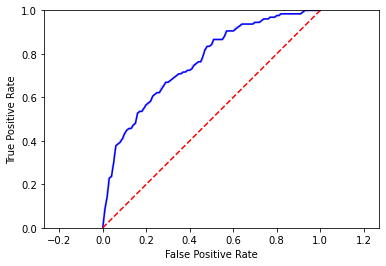

In [40]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/013--0.394--0.426.hdf5'
          
          
          
          
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

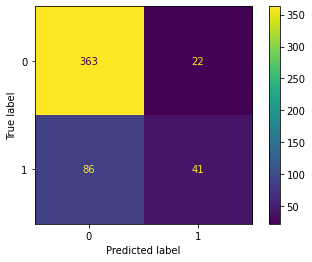

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7808856237783919


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7263728397586665
78/78 - 16s - loss: 0.3044 - auc: 0.9107 - val_loss: 0.4607 - val_auc: 0.7816 - 16s/epoch - 205ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8081148480150974


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7624092442990081
78/78 - 16s - loss: 0.2789 - auc: 0.9247 - val_loss: 0.4540 - val_auc: 0.8082 - 16s/epoch - 201ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8007009503268856


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7357398507004805
78/78 - 16s - loss: 0.2395 - auc: 0.9466 - val_loss: 0.4675 - val_auc: 0.8014 - 16s/epoch - 201ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7654063040596706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7130994989262706
78/78 - 16s - loss: 0.2132 - auc: 0.9573 - val_loss: 0.6063 - val_auc: 0.7630 - 16s/epoch - 202ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7949270966727326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7361284384906431
78/78 - 16s - loss: 0.2146 - auc: 0.9571 - val_loss: 0.4837 - val_auc: 0.7902 - 16s/epoch - 203ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7709330277908831


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7265569076592698
78/78 - 16s - loss: 0.1693 - auc: 0.9739 - val_loss: 0.9257 - val_auc: 0.7077 - 16s/epoch - 208ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.780413830289142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7363738623581143
78/78 - 16s - loss: 0.1514 - auc: 0.9795 - val_loss: 0.6570 - val_auc: 0.7701 - 16s/epoch - 205ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7343128664824424


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6949176807444524
78/78 - 16s - loss: 0.1516 - auc: 0.9794 - val_loss: 0.8049 - val_auc: 0.7199 - 16s/epoch - 203ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7803464312192492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7230391655588506
78/78 - 16s - loss: 0.1149 - auc: 0.9884 - val_loss: 0.8824 - val_auc: 0.7576 - 16s/epoch - 202ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.807867718092157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7298701298701299
78/78 - 16s - loss: 0.1309 - auc: 0.9836 - val_loss: 0.7304 - val_auc: 0.8092 - 16s/epoch - 203ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7491181955022355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7109315880969425
78/78 - 16s - loss: 0.0799 - auc: 0.9938 - val_loss: 0.9112 - val_auc: 0.7258 - 16s/epoch - 202ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7944777695401137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7116883116883117
78/78 - 16s - loss: 0.1050 - auc: 0.9881 - val_loss: 0.9289 - val_auc: 0.7621 - 16s/epoch - 202ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7554761744287929


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7281419368033542
78/78 - 16s - loss: 0.0757 - auc: 0.9941 - val_loss: 0.8866 - val_auc: 0.7488 - 16s/epoch - 202ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.772595538181573


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7322016566111055
78/78 - 16s - loss: 0.0708 - auc: 0.9957 - val_loss: 1.0701 - val_auc: 0.7286 - 16s/epoch - 204ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7849295679719619


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7121178034563861
78/78 - 16s - loss: 0.0653 - auc: 0.9955 - val_loss: 1.1743 - val_auc: 0.7150 - 16s/epoch - 205ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7663723573948013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7221801820227016
78/78 - 16s - loss: 0.0662 - auc: 0.9953 - val_loss: 1.0427 - val_auc: 0.7353 - 16s/epoch - 203ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7778751319898451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7286225585438183
78/78 - 16s - loss: 0.0420 - auc: 0.9983 - val_loss: 1.1391 - val_auc: 0.6948 - 16s/epoch - 204ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.770169171665431


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6964822578995807
78/78 - 16s - loss: 0.0304 - auc: 0.9992 - val_loss: 1.2676 - val_auc: 0.7239 - 16s/epoch - 205ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7647547797173733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7368647100930565
78/78 - 17s - loss: 0.0619 - auc: 0.9960 - val_loss: 0.9831 - val_auc: 0.7418 - 17s/epoch - 214ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7748871065579295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7236118212496165
78/78 - 16s - loss: 0.0620 - auc: 0.9950 - val_loss: 0.9447 - val_auc: 0.7431 - 16s/epoch - 201ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


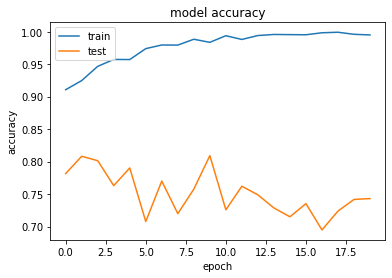

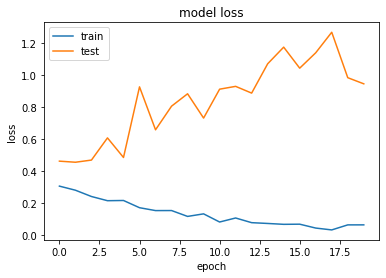

In [42]:
history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
print(history.history.keys())
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()